In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'churn-modelling:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F13831%2F18644%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240629%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240629T151221Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc204067894f8424aa212d4988b824614e5bb732ef80fa44dafa57bc9ba33af077a771b61b551ff5b8dc80302280a85ab940bd2ead4110fae5e4e18d59a29f23ae298e8fb8540cccdaf53a20325b6cfb34037b3f8e422dcfb4f3cad40a9bee5871a0e7df0ae6ce3c1c3a5cd19db00c70405e27f87b74bfc2edc62988cf7eb2790831f165e3d0076deb4ce93a83f3a5def7ee0363fe63afbb2a025486c814c35ad4c238e06953227f519625ecfb30fdb9d5fe3c791d080ab5a73c62a4d018c077468e8c47275d5d80f01c315b1f8b4a64fc952a6da34d46ab2a66c0c2dd277443d835e11cbc9bb4b6443b12875300ec38547b8ba3bd3455b77d9264d90e027b0c6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 267794 bytes downloaded
Downloaded and uncompressed: churn-modelling
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-modelling/Churn_Modelling.csv


In [3]:
df = pd.read_csv("/kaggle/input/churn-modelling/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
df.duplicated().sum()

0

In [6]:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [7]:
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [8]:
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [9]:
df.drop(columns=['RowNumber','CustomerId','Surname'],inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [10]:
df =pd.get_dummies(df,columns=['Geography','Gender'],drop_first=True)


In [11]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df.drop(columns=['Exited']),df['Exited'],test_size=0.2,random_state=42)

In [13]:
X_train.shape


(8000, 11)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [15]:
X_train_scaled

array([[ 0.35649971, -0.6557859 ,  0.34567966, ..., -0.57946723,
        -0.57638802,  0.91324755],
       [-0.20389777,  0.29493847, -0.3483691 , ...,  1.72572313,
        -0.57638802,  0.91324755],
       [-0.96147213, -1.41636539, -0.69539349, ..., -0.57946723,
         1.73494238,  0.91324755],
       ...,
       [ 0.86500853, -0.08535128, -1.38944225, ..., -0.57946723,
        -0.57638802, -1.09499335],
       [ 0.15932282,  0.3900109 ,  1.03972843, ..., -0.57946723,
        -0.57638802,  0.91324755],
       [ 0.47065475,  1.15059039, -1.38944225, ...,  1.72572313,
        -0.57638802,  0.91324755]])

In [16]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [17]:
model = Sequential()
model.add(Dense(3,activation='sigmoid',input_dim=11))
model.add(Dense(1,activation='sigmoid'))


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 36        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 40 (160.00 Byte)
Trainable params: 40 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model.compile(loss='binary_crossentropy',optimizer='Adam')


In [20]:
model.fit(X_train_scaled,y_train,epochs=10)

Epoch 1/10
250/250 [==============================] - 1s 2ms/step - loss: 0.5077
Epoch 2/10
250/250 [==============================] - 0s 2ms/step - loss: 0.4826
Epoch 3/10
250/250 [==============================] - 1s 2ms/step - loss: 0.4666
Epoch 4/10
250/250 [==============================] - 0s 2ms/step - loss: 0.4553
Epoch 5/10
250/250 [==============================] - 1s 2ms/step - loss: 0.4471
Epoch 6/10
250/250 [==============================] - 0s 2ms/step - loss: 0.4412
Epoch 7/10
250/250 [==============================] - 0s 2ms/step - loss: 0.4368
Epoch 8/10
250/250 [==============================] - 1s 2ms/step - loss: 0.4337
Epoch 9/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4312
Epoch 10/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4292


In [21]:
model.layers[0].get_weights()

[array([[ 3.4768900e-01, -2.3352565e-01,  1.9022465e-01],
        [-4.5510921e-01, -2.2317085e+00, -1.0719308e+00],
        [-1.1898766e-01,  3.1308216e-01, -4.1318208e-02],
        [ 2.4076324e-02, -4.6607420e-01, -2.6407295e-01],
        [ 1.8720536e-02,  3.0747725e-02,  1.2192828e-01],
        [-4.6029694e-02, -2.6107517e-01,  2.1831295e-01],
        [ 1.0867409e+00,  3.9789128e-01,  4.5473957e-01],
        [-6.9329955e-02,  3.3092719e-02, -2.0278112e-03],
        [-5.9885436e-01, -1.6882171e-01, -6.2885487e-01],
        [-1.6222054e-01, -4.1245499e-01,  2.3550583e-01],
        [ 5.7523757e-01,  3.6330047e-01,  3.6036220e-01]], dtype=float32),
 array([-0.00320691,  0.13972132,  0.04675029], dtype=float32)]

In [25]:
model.layers[1].get_weights()

[array([[-0.860163 ],
        [-1.0901338],
        [-1.5133181]], dtype=float32),
 array([0.17131016], dtype=float32)]

In [26]:
y_log = model.predict(X_test_scaled)

63/63 [==============================] - 1s 6ms/step


In [27]:
y_pred = np.where(y_log>0.5,1,0)

In [28]:
from sklearn.metrics import accuracy_score


In [29]:
accuracy_score(y_test,y_pred)

0.816

In [30]:
#We can increase the number of epoch for better output.
#We can change the activation function to relu for better output.
#We can increase the number of nodes in the hidden layer.


In [31]:
model2 = Sequential()

In [32]:
model2.add(Dense(11,activation='relu',input_dim=11))
model2.add(Dense(11,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))


In [33]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 11)                132       
                                                                 
 dense_3 (Dense)             (None, 11)                132       
                                                                 
 dense_4 (Dense)             (None, 1)                 12        
                                                                 
Total params: 276 (1.08 KB)
Trainable params: 276 (1.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
model2.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [35]:
history = model2.fit(X_train_scaled,y_train,epochs=100,validation_split=0.2)
#Our training as well as validation accuracy should increase.
#It is overfitting if training accuracy increases but validation accuracy decreases.

Epoch 1/100
200/200 [==============================] - 2s 4ms/step - loss: 0.5681 - accuracy: 0.7333 - val_loss: 0.4905 - val_accuracy: 0.7987
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4775 - accuracy: 0.7955 - val_loss: 0.4498 - val_accuracy: 0.8019
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4503 - accuracy: 0.8009 - val_loss: 0.4265 - val_accuracy: 0.8181
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4333 - accuracy: 0.8147 - val_loss: 0.4135 - val_accuracy: 0.8244
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4230 - accuracy: 0.8198 - val_loss: 0.4053 - val_accuracy: 0.8294
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4145 - accuracy: 0.8263 - val_loss: 0.3986 - val_accuracy: 0.8313
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4050 - accuracy: 0.8292 - val_loss: 0.3911 - val_accuracy: 0.8375

In [36]:
model2.layers[0].get_weights()

[array([[ 0.11675181, -0.16322394, -0.03174093,  0.24361038,  0.19710775,
          0.14971559,  0.07748897, -0.18964875,  0.03232292, -0.12935856,
          0.06890892],
        [-0.5518898 , -0.5870502 , -0.2640696 ,  0.26975146,  0.7982258 ,
          0.39422533, -0.6268874 ,  1.0913233 ,  0.4566572 , -0.3570232 ,
         -0.89404523],
        [ 0.4993591 , -0.22849344, -0.2529377 , -0.19063996,  0.04361731,
         -0.20506257, -0.11037672, -0.3521538 , -0.18571164, -0.06311362,
         -0.1442317 ],
        [-0.03704141,  0.38089383, -0.429111  ,  0.34264964, -0.77885497,
         -0.23564287, -0.16678871,  0.8361809 ,  0.00400427, -0.91065943,
          0.1345148 ],
        [ 0.07894201,  0.237183  ,  1.4827676 , -0.32487804, -0.199743  ,
         -0.41993147,  0.38822836,  0.49100494,  0.14740148, -0.20468898,
         -0.11367603],
        [ 0.24229068, -0.16285902, -0.03826321, -0.25553784, -0.03480392,
         -0.07545648, -0.09382424, -0.13998148,  0.12084889, -0.0288840

In [37]:
model2.layers[1].get_weights()

[array([[ 0.67170477,  0.12158665, -0.82820153,  0.21828417,  0.4003741 ,
          0.2180199 , -0.2952394 , -0.291423  ,  0.43860868,  0.2976272 ,
         -0.3806189 ],
        [-0.50177366,  0.1586241 ,  0.42839503, -0.63517606,  0.21004376,
          0.1132506 , -0.11273513,  0.0829225 ,  0.4991075 , -0.0686408 ,
         -0.16440473],
        [ 0.6823657 ,  0.15858042, -0.48279974, -0.64360887, -0.32846224,
          0.05974603, -0.49757773,  1.0489194 ,  0.28828466,  0.5317291 ,
         -0.10001736],
        [-0.79121584,  0.6475935 ,  0.54043096, -0.33770597, -0.10839513,
          0.07811428,  0.0991216 ,  0.25780708,  0.5853472 , -0.07342105,
         -0.6065057 ],
        [-0.49668464, -0.5502174 ,  0.22572784,  0.06154049,  0.67694086,
         -0.28896123,  0.39177388, -0.13206233, -0.23950619,  0.43450904,
          0.7143233 ],
        [ 0.27880043,  0.07320056,  0.25737554,  0.51447815, -0.15557651,
         -0.45473185,  0.3415439 , -0.04599626,  0.01362342,  0.1547513

In [38]:
model2.layers[2].get_weights()

[array([[ 0.9801959 ],
        [-0.9977223 ],
        [ 0.81799   ],
        [ 1.0863343 ],
        [-0.7509851 ],
        [ 1.1351539 ],
        [ 1.2591349 ],
        [ 1.8836325 ],
        [-0.61198425],
        [-0.35049966],
        [-0.69436026]], dtype=float32),
 array([-0.1472819], dtype=float32)]

In [39]:
y2_log = model2.predict(X_test_scaled)

63/63 [==============================] - 0s 2ms/step


In [40]:
y2_pred = np.where(y2_log>0.5,1,0)

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y2_pred)

0.861

In [42]:
#We should plot the graph of any stage to get idea about the performance of the neural network.

In [43]:
import matplotlib.pyplot as plt


In [44]:
history.history
#We get a dictionary of the accuracy,loss,validation_accuracy.validation_loss of all the epochs.

{'loss': [0.5680819153785706,
  0.47754183411598206,
  0.4503060281276703,
  0.4333448112010956,
  0.4230080544948578,
  0.4144595265388489,
  0.40502506494522095,
  0.3939339816570282,
  0.3812517821788788,
  0.37048855423927307,
  0.36180004477500916,
  0.3558070659637451,
  0.3508293628692627,
  0.34762123227119446,
  0.34425684809684753,
  0.34187230467796326,
  0.33948075771331787,
  0.3384624123573303,
  0.33617427945137024,
  0.33562782406806946,
  0.33407461643218994,
  0.33324146270751953,
  0.3325977325439453,
  0.3322151303291321,
  0.33110418915748596,
  0.3310225307941437,
  0.3302238881587982,
  0.32979217171669006,
  0.3289583623409271,
  0.32917189598083496,
  0.32802170515060425,
  0.3274402320384979,
  0.32745760679244995,
  0.3269416391849518,
  0.3262815475463867,
  0.3260170817375183,
  0.32577836513519287,
  0.3253783881664276,
  0.3247112035751343,
  0.3245273232460022,
  0.3241702616214752,
  0.324179083108902,
  0.3236849904060364,
  0.32315754890441895,
  0.32

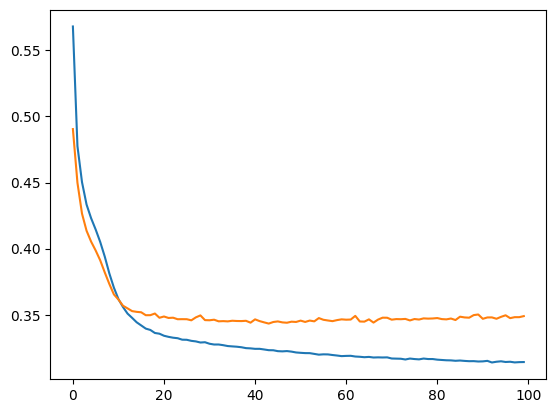

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [46]:
#from the above graph, we get the idea of overfitting.


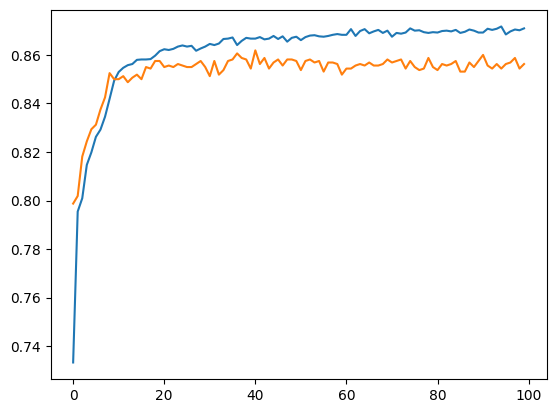

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [48]:
#As we can see the gap betweent the plot, we can say some sort of overfitting is there.